In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer

# same change this if needed
DATA_FILE = r"C:\Users\yacin\Desktop\M2\meds\tme1\WikiTableQuestions\WikiTableQuestions\data\training.tsv"

# Load questions
df = pd.read_csv(DATA_FILE, sep='\t')
questions = df['utterance'].dropna().tolist()
print(f"Loaded {len(questions)} questions")

# --- Question length stats ---
q_lengths = [len(q.split()) for q in questions]
print(f"Mean question length: {sum(q_lengths)/len(q_lengths):.2f} words")
print(f"Median question length: {pd.Series(q_lengths).median():.2f} words")

Loaded 14149 questions
Mean question length: 9.99 words
Median question length: 9.00 words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yacin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


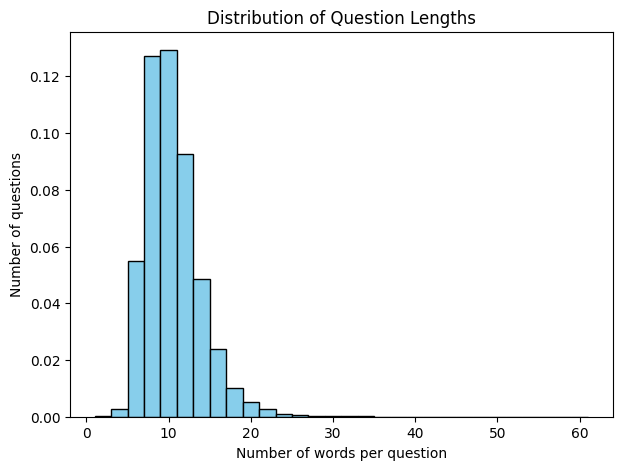

In [2]:
plt.figure(figsize=(7,5))
plt.hist(q_lengths, bins=30, color='skyblue', edgecolor='black', density=True)
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of words per question")
plt.ylabel("Number of questions")
plt.savefig("question_length_distribution.png")
plt.show()

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def ngrams_freq(questions, ngram_range=(2,2), top_n=20, wordcloud=True, ignore_stopwords=True):
	if ignore_stopwords:
		vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
	else:
		vectorizer = TfidfVectorizer(ngram_range=ngram_range)
	X = vectorizer.fit_transform(questions)
	sum_words = X.sum(axis=0)
	ngram_freq = [(ngram, sum_words[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
	ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_n]
	ngram_dict = dict(ngram_freq)
	if wordcloud:
		wc = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(ngram_dict)
		plt.figure(figsize=(15,7))
		plt.imshow(wc, interpolation='bilinear')
		plt.axis('off')
		plt.tight_layout()
		plt.show()
	return ngram_freq

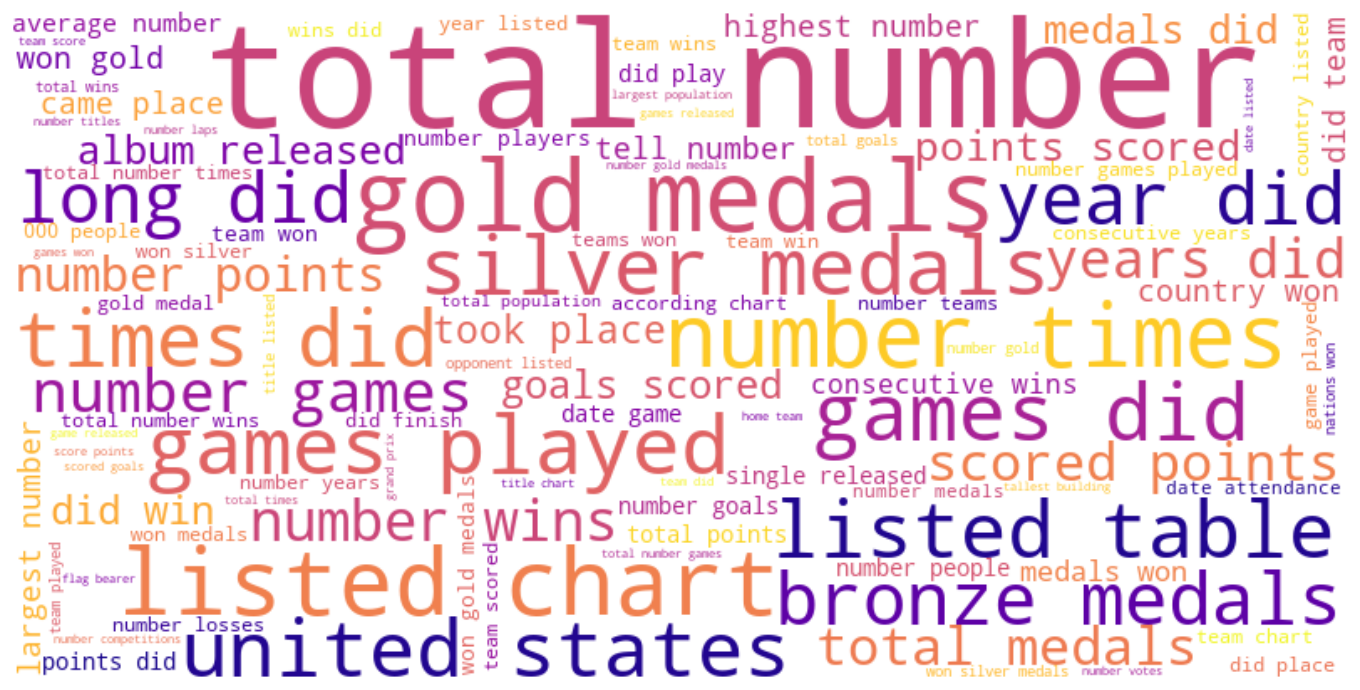

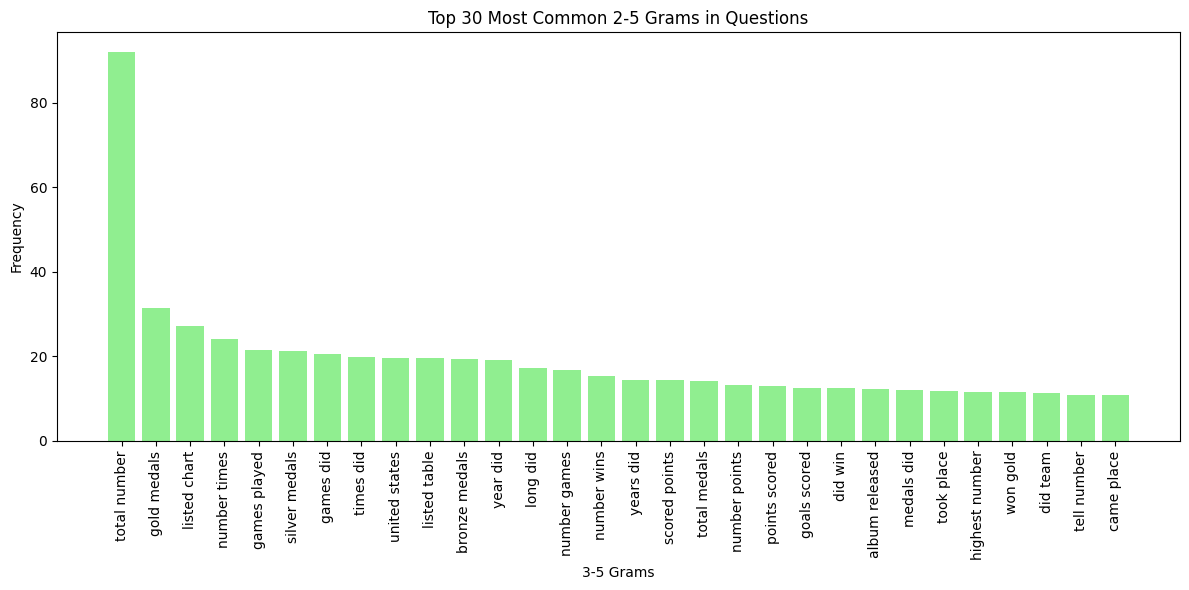

In [48]:
ngrams = ngrams_freq(questions, ngram_range=(2,5), top_n=100, ignore_stopwords=True)
ngrams, freqs = zip(*ngrams)
plt.figure(figsize=(12,6))
plt.bar(ngrams[:30], freqs[:30], color='lightgreen')
plt.xticks(rotation=90)
plt.title("Top 30 Most Common 2-5 Grams in Questions")
plt.xlabel("3-5 Grams")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
import gensim
tokenized_questions = [nltk.word_tokenize(q.lower()) for q in questions]
w2v_model = gensim.models.Word2Vec(sentences=tokenized_questions, vector_size=120, window=7, min_count=2, workers=4)
w2v_model.save("models/question_word2vec.model")

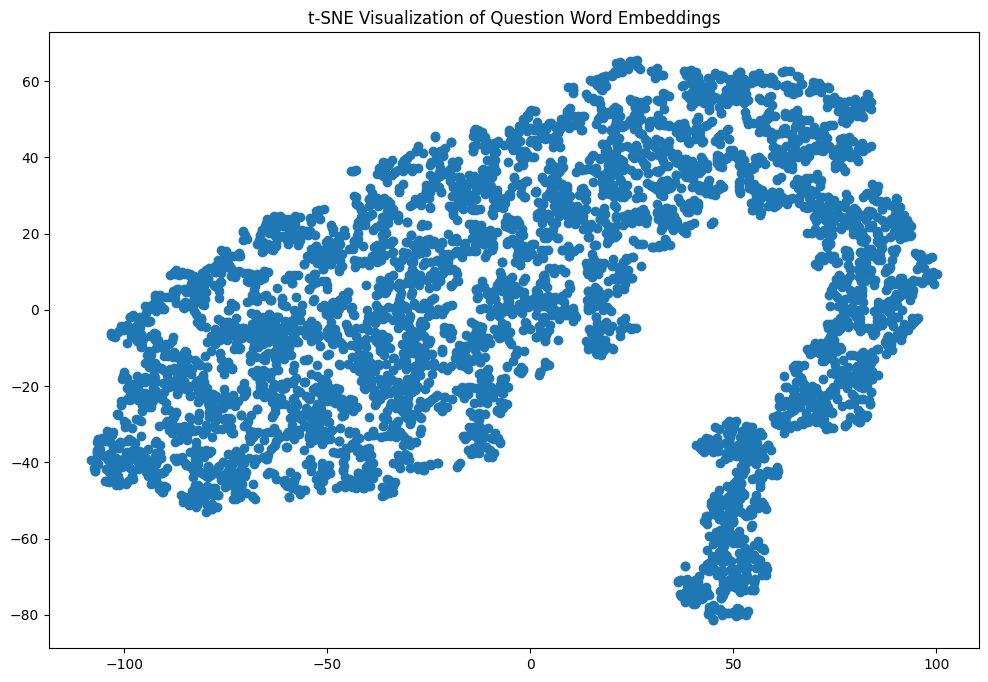

In [46]:
from sklearn.manifold import TSNE
import numpy as np
words = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in words])
tsne = TSNE(n_components=2, random_state=42, perplexity=25, n_iter=2000)
word_vecs_2d = tsne.fit_transform(word_vectors)
plt.figure(figsize=(12,8))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])
plt.title("t-SNE Visualization of Question Word Embeddings")
plt.savefig("question_word_embeddings_tsne.png")
plt.show()


# chatgpt

In [ ]:
import os
import re
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

BASE_DIR = os.path.normpath("WikiTableQuestions\\WikiTableQuestions")
DATA_DIR = os.path.join(BASE_DIR, "data")
CSV_BASE_DIR = os.path.join(BASE_DIR, "csv")
TRAIN_PATH = os.path.join(DATA_DIR, "training.tsv")
OUTPUT_SUMMARY = os.path.join(BASE_DIR, "table_metadata_summary.csv")
COLUMN_PROFILE_DIR = os.path.join(BASE_DIR, "table_column_profiles")
BAD_FILES_LOG = os.path.join(BASE_DIR, "bad_files.log")
os.makedirs(COLUMN_PROFILE_DIR, exist_ok=True)
train_df = pd.read_csv(TRAIN_PATH, sep="\t")

def resolve_csv_path(context_path):
    return os.path.normpath(os.path.join(BASE_DIR, context_path))

def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    try:
        return pd.read_csv(path)
    except Exception:
        try:
            return pd.read_csv(path, sep="\t")
        except Exception:
            try:
                return pd.read_csv(path, engine="python", on_bad_lines="skip")
            except Exception as e:
                raise e

pattern_alnum = re.compile(r"\w", flags=re.UNICODE)  # détecte lettres/chiffres/underscore

def is_empty_cell(val):
    if pd.isna(val):
        return True
    s = str(val).strip()
    if s == "":
        return True
    if pattern_alnum.search(s):
        return False # s contient au moins une lettre ou un chiffre -> non vide
    return True  #si uniquement ponctuation = vide

def profile_column(col_series):
    raw = col_series
    n = len(raw)
    empties = raw.apply(is_empty_cell)
    missing_ratio = empties.sum() / n if n > 0 else np.nan
    numeric_mask = pd.to_numeric(raw, errors="coerce").notna()
    numeric_ratio = numeric_mask.sum() / n if n > 0 else 0.0
    unique_vals = raw[~empties].astype(str).str.strip()
    unique_count = unique_vals.nunique()
    top_values = unique_vals.value_counts().head(5).to_dict()
    lengths = unique_vals.apply(len)
    avg_len = lengths.mean() if len(lengths) > 0 else 0.0
    median_len = lengths.median() if len(lengths) > 0 else 0.0
    special_only_count = ((raw.apply(lambda x: (not pd.isna(x)) and str(x).strip() != "" and not pattern_alnum.search(str(x)) ))).sum()
    special_only_ratio = special_only_count / n if n > 0 else 0.0

    return {
        "n_cells": int(n),
        "missing_ratio": float(round(missing_ratio, 6)) if not pd.isna(missing_ratio) else np.nan,
        "numeric_ratio": float(round(numeric_ratio, 6)),
        "unique_count": int(unique_count),
        "top_values": json.dumps(top_values, ensure_ascii=False),
        "avg_len_non_empty": float(round(avg_len, 3)),
        "median_len_non_empty": float(round(median_len, 3)),
        "special_only_ratio": float(round(special_only_ratio, 6)),
    }

# Analyse structurelle des tables (profil global + colonnes)
table_summaries = []
bad_files = []

for path in tqdm(train_df["context"].unique(), desc="Analyse des tables"):
    csv_path = resolve_csv_path(path)
    try:
        df = safe_read_csv(csv_path)
    except Exception as e:
        bad_files.append(f"{csv_path} :: {repr(e)}")
        print(f"Impossible de lire {csv_path}: {e}")
        continue

    df.columns = [str(c).strip() for c in df.columns]
    n_rows, n_cols = df.shape
    col_names = df.columns.tolist()

    # Calcul global de "vide" sur toute la table 
    #use instead DataFrame.map instead of applymap
    flatten = df.stack().map(is_empty_cell)
    table_missing_cells = flatten.values.sum()
    total_cells = n_rows * n_cols if (n_rows * n_cols) > 0 else 1
    table_missing_ratio = table_missing_cells / total_cells

    # par-colonne profiles (et sauvegarde individuelle)
    col_profiles = {}
    col_profile_rows = []
    for col in df.columns:
        prof = profile_column(df[col])
        prof_row = {"column": col}
        prof_row.update(prof)
        col_profile_rows.append(prof_row)
        col_profiles[col] = prof

    numeric_cols = sum(1 for v in col_profiles.values() if v["numeric_ratio"] > 0.5)
    cols_mostly_empty = sum(1 for v in col_profiles.values() if v["missing_ratio"] > 0.5)
    avg_col_cardinality = np.mean([v["unique_count"] for v in col_profiles.values()]) if len(col_profiles) > 0 else 0
    median_col_cardinality = np.median([v["unique_count"] for v in col_profiles.values()]) if len(col_profiles) > 0 else 0
    avg_cell_length = np.mean([v["avg_len_non_empty"] for v in col_profiles.values()]) if len(col_profiles) > 0 else 0

    # duplicate col names
    col_name_counts = Counter(col_names)
    dup_cols = [c for c, cnt in col_name_counts.items() if cnt > 1]
    has_dup_cols = len(dup_cols) > 0

    table_summary = {
        "context_path": path,
        "absolute_path": csv_path,
        "n_rows": int(n_rows),
        "n_cols": int(n_cols),
        "table_missing_ratio": float(round(table_missing_ratio, 6)),
        "n_numeric_cols_est": int(numeric_cols),
        "n_cols_mostly_empty": int(cols_mostly_empty),
        "avg_col_cardinality": float(round(avg_col_cardinality, 3)),
        "median_col_cardinality": float(round(median_col_cardinality, 3)),
        "avg_cell_length": float(round(avg_cell_length, 3)),
        "has_duplicate_column_names": bool(has_dup_cols),
        "duplicate_column_names": ", ".join(dup_cols) if has_dup_cols else "",
    }

    table_summaries.append(table_summary)

    safe_name = re.sub(r"[^\w\-_.() ]+", "_", path)  # file-system safe
    col_profile_path = os.path.join(COLUMN_PROFILE_DIR, f"{safe_name}_columns.csv")
    pd.DataFrame(col_profile_rows).to_csv(col_profile_path, index=False)



Analyse des tables: 100%|██████████| 1679/1679 [00:37<00:00, 44.25it/s]


In [31]:
summary_df = pd.DataFrame(table_summaries)
summary_df.to_csv(OUTPUT_SUMMARY, index=False)
print("Nombre total de tables analysées :", len(summary_df))
if len(summary_df) > 0:
    print("Moyenne de colonnes :", summary_df["n_cols"].mean().round(1))
    print("Moyenne de lignes :", summary_df["n_rows"].mean().round(1))
    print("Proportion de cellules manquantes (table_missing_ratio mean) :", ((summary_df["table_missing_ratio"]*summary_df["n_rows"]*summary_df["n_cols"]).sum()/ (summary_df["n_rows"]*summary_df["n_cols"]).sum()).round(3))
    print("Proportion de colonnes majoritairement vides :", (summary_df["n_cols_mostly_empty"] / summary_df["n_cols"]).mean().round(3))

Nombre total de tables analysées : 1679
Moyenne de colonnes : 6.2
Moyenne de lignes : 28.2
Proportion de cellules manquantes (table_missing_ratio mean) : 0.02
Proportion de colonnes majoritairement vides : 0.051


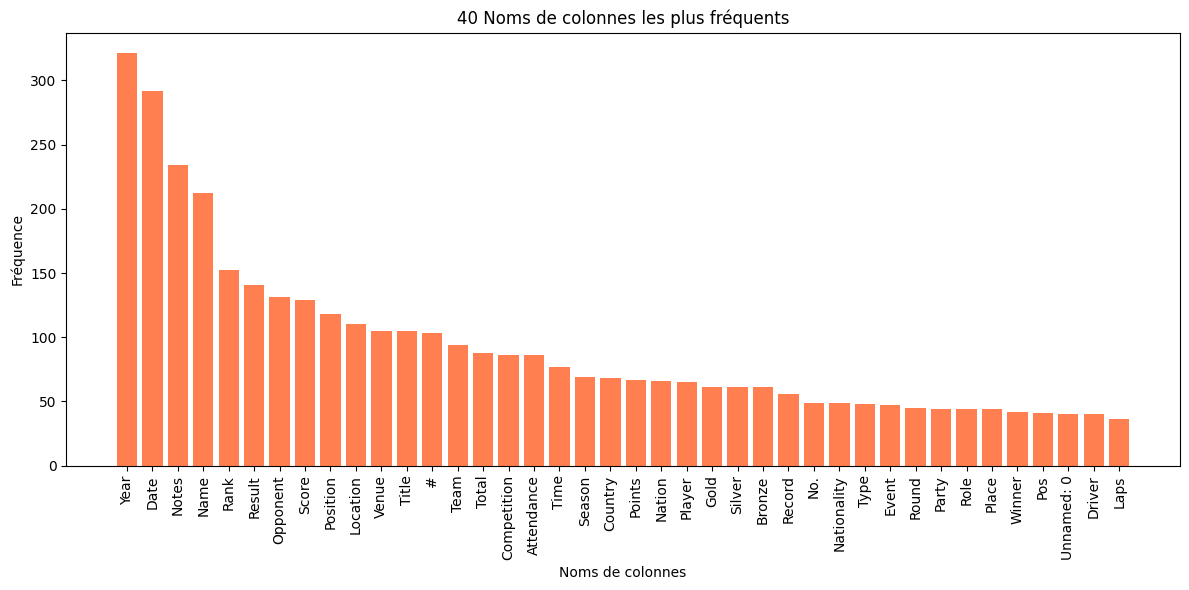

<Figure size 640x480 with 0 Axes>

In [46]:
# most common column names
from matplotlib import pyplot as plt

all_col_names = []
for path in summary_df["context_path"]:
	csv_path = resolve_csv_path(path)
	df = safe_read_csv(csv_path)
	all_col_names.extend([str(c).strip() for c in df.columns])

col_name_counts = Counter(all_col_names)
most_common_cols = col_name_counts.most_common(40)
cols, counts = zip(*most_common_cols)

plt.figure(figsize=(12,6))
plt.bar(cols, counts, color='coral')
plt.xticks(rotation=90)
plt.title("40 Noms de colonnes les plus fréquents")
plt.xlabel("Noms de colonnes")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()
plt.savefig("analyses/most_common_column_names.png")

In [2]:
# Analyse de la retrievabilité des targets dans les tables (soit un match direct ou avec une différence légere)
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

BASE_DIR = os.path.normpath("WikiTableQuestions\\WikiTableQuestions")
TRAIN_PATH = os.path.join(BASE_DIR, "data", "training.tsv")

train_df = pd.read_csv(TRAIN_PATH, sep="\t")

def resolve_csv_path(context_path):
    return os.path.normpath(os.path.join(BASE_DIR, context_path))

def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except:
        try:
            return pd.read_csv(path, sep="\t")
        except:
            return pd.read_csv(path, engine="python", on_bad_lines="skip")

def fuzzy_contains(df, target):
    """Retourne True si une cellule est très proche du target (>=0.85 similarité)."""
    target_str = str(target).strip().lower()
    if target_str == "":
        return False
    for val in df.astype(str).values.flatten():
        s = str(val).strip().lower()
        if s == target_str:
            return True
        if SequenceMatcher(None, s, target_str).ratio() > 0.85:
            return True
    return False

retriev_results = []
for i, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Checking retrievability"):
    csv_path = resolve_csv_path(row['context'])
    try:
        df = safe_read_csv(csv_path)
        found_exact = df.astype(str).isin([str(row['targetValue'])]).any().any()
        found_fuzzy = fuzzy_contains(df, row['targetValue'])
        retriev_results.append({
            "id": row['id'],
            "context": row['context'],
            "found_exact": found_exact,
            "found_fuzzy": found_fuzzy
        })
    except:
        retriev_results.append({
            "id": row['id'],
            "context": row['context'],
            "found_exact": False,
            "found_fuzzy": False
        })

retriev_df = pd.DataFrame(retriev_results)
train_df = train_df.merge(retriev_df, on=["id", "context"], how="left")

print("Proportion de cibles trouvées (exact):", train_df["found_exact"].mean())
print("Proportion de cibles trouvées (fuzzy):", train_df["found_fuzzy"].mean())

train_df.to_csv("analyses/training_with_retrievability.tsv", sep="\t", index=False)


Checking retrievability: 100%|██████████| 14149/14149 [00:45<00:00, 308.78it/s]

Proportion de cibles trouvées (exact): 0.5755883808042971
Proportion de cibles trouvées (fuzzy): 0.5986995547388508


In [9]:
# clustering des schémas de tables by similarity of column names
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

summary_path = "analyses/summary_structural_analyse.csv"
summary_df = pd.read_csv(summary_path)

summary_df["schema_text"] = summary_df["col_names"].fillna("")

vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=2)
X = vectorizer.fit_transform(summary_df["schema_text"])

n_clusters = min(20, len(summary_df)//10 + 2)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
summary_df["schema_cluster"] = kmeans.fit_predict(X)

print("Score de silhouette :", silhouette_score(X, summary_df["schema_cluster"]))
summary_df.to_csv("analyses/tables_schema_clustered.csv", index=False)


KeyError: 'col_names'